In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-5, 5))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(4357, 5) (2932, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 762ms/step - loss: 35717.5703
Epoch 2/3500
1/1 [==============================] - 0s 7ms/step - loss: 35520.4180
Epoch 3/3500
1/1 [==============================] - 0s 6ms/step - loss: 35375.3320
Epoch 4/3500
1/1 [==============================] - 0s 5ms/step - loss: 35250.4375
Epoch 5/3500
1/1 [==============================] - 0s 6ms/step - loss: 35136.8438
Epoch 6/3500
1/1 [==============================] - 0s 5ms/step - loss: 35030.5977
Epoch 7/3500
1/1 [==============================] - 0s 8ms/step - loss: 34929.5312
Epoch 8/3500
1/1 [==============================] - 0s 6ms/step - loss: 34832.2969
Epoch 9/3500
1/1 [==============================] - 0s 8ms/step - loss: 34737.9883
Epoch 10/3500
1/1 [==============================] - 0s 5ms/step - loss: 34645.9805
Epoch 11/3500
1/1 [==============================] - 0s 7ms/step - loss: 34555.8438
Epoch 12/3500
1/1 [==============================] - 0s 5ms/step - loss: 34467.2500

1/1 [==============================] - 0s 4ms/step - loss: 29743.2578
Epoch 99/3500
1/1 [==============================] - 0s 3ms/step - loss: 29713.1445
Epoch 100/3500
1/1 [==============================] - 0s 4ms/step - loss: 29683.3594
Epoch 101/3500
1/1 [==============================] - 0s 4ms/step - loss: 29653.8906
Epoch 102/3500
1/1 [==============================] - 0s 4ms/step - loss: 29624.7383
Epoch 103/3500
1/1 [==============================] - 0s 4ms/step - loss: 29595.8867
Epoch 104/3500
1/1 [==============================] - 0s 4ms/step - loss: 29567.3379
Epoch 105/3500
1/1 [==============================] - 0s 4ms/step - loss: 29539.0820
Epoch 106/3500
1/1 [==============================] - 0s 3ms/step - loss: 29511.1133
Epoch 107/3500
1/1 [==============================] - 0s 3ms/step - loss: 29483.4277
Epoch 108/3500
1/1 [==============================] - 0s 4ms/step - loss: 29456.0195
Epoch 109/3500
1/1 [==============================] - 0s 4ms/step - loss: 29428.8

1/1 [==============================] - 0s 4ms/step - loss: 27744.7031
Epoch 195/3500
1/1 [==============================] - 0s 5ms/step - loss: 27729.4766
Epoch 196/3500
1/1 [==============================] - 0s 4ms/step - loss: 27714.3164
Epoch 197/3500
1/1 [==============================] - 0s 4ms/step - loss: 27699.2188
Epoch 198/3500
1/1 [==============================] - 0s 4ms/step - loss: 27684.1875
Epoch 199/3500
1/1 [==============================] - 0s 4ms/step - loss: 27669.2188
Epoch 200/3500
1/1 [==============================] - 0s 4ms/step - loss: 27654.3164
Epoch 201/3500
1/1 [==============================] - 0s 3ms/step - loss: 27639.4766
Epoch 202/3500
1/1 [==============================] - 0s 3ms/step - loss: 27624.6953
Epoch 203/3500
1/1 [==============================] - 0s 4ms/step - loss: 27609.9766
Epoch 204/3500
1/1 [==============================] - 0s 3ms/step - loss: 27595.3184
Epoch 205/3500
1/1 [==============================] - 0s 3ms/step - loss: 27580.

1/1 [==============================] - 0s 4ms/step - loss: 26499.0273
Epoch 291/3500
1/1 [==============================] - 0s 3ms/step - loss: 26487.6855
Epoch 292/3500
1/1 [==============================] - 0s 3ms/step - loss: 26476.3672
Epoch 293/3500
1/1 [==============================] - 0s 3ms/step - loss: 26465.0742
Epoch 294/3500
1/1 [==============================] - 0s 3ms/step - loss: 26453.8008
Epoch 295/3500
1/1 [==============================] - 0s 4ms/step - loss: 26442.5547
Epoch 296/3500
1/1 [==============================] - 0s 3ms/step - loss: 26431.3301
Epoch 297/3500
1/1 [==============================] - 0s 3ms/step - loss: 26420.1289
Epoch 298/3500
1/1 [==============================] - 0s 3ms/step - loss: 26408.9512
Epoch 299/3500
1/1 [==============================] - 0s 4ms/step - loss: 26397.7930
Epoch 300/3500
1/1 [==============================] - 0s 3ms/step - loss: 26386.6602
Epoch 301/3500
1/1 [==============================] - 0s 3ms/step - loss: 26375.

1/1 [==============================] - 0s 3ms/step - loss: 25498.7305
Epoch 387/3500
1/1 [==============================] - 0s 4ms/step - loss: 25489.0859
Epoch 388/3500
1/1 [==============================] - 0s 3ms/step - loss: 25479.4551
Epoch 389/3500
1/1 [==============================] - 0s 3ms/step - loss: 25469.8359
Epoch 390/3500
1/1 [==============================] - 0s 3ms/step - loss: 25460.2324
Epoch 391/3500
1/1 [==============================] - 0s 4ms/step - loss: 25450.6406
Epoch 392/3500
1/1 [==============================] - 0s 3ms/step - loss: 25441.0625
Epoch 393/3500
1/1 [==============================] - 0s 4ms/step - loss: 25431.4961
Epoch 394/3500
1/1 [==============================] - 0s 3ms/step - loss: 25421.9473
Epoch 395/3500
1/1 [==============================] - 0s 4ms/step - loss: 25412.4102
Epoch 396/3500
1/1 [==============================] - 0s 3ms/step - loss: 25402.8828
Epoch 397/3500
1/1 [==============================] - 0s 4ms/step - loss: 25393.

1/1 [==============================] - 0s 4ms/step - loss: 24628.4648
Epoch 483/3500
1/1 [==============================] - 0s 4ms/step - loss: 24619.9355
Epoch 484/3500
1/1 [==============================] - 0s 3ms/step - loss: 24611.3906
Epoch 485/3500
1/1 [==============================] - 0s 3ms/step - loss: 24602.8672
Epoch 486/3500
1/1 [==============================] - 0s 4ms/step - loss: 24594.3516
Epoch 487/3500
1/1 [==============================] - 0s 3ms/step - loss: 24585.8633
Epoch 488/3500
1/1 [==============================] - 0s 3ms/step - loss: 24577.3203
Epoch 489/3500
1/1 [==============================] - 0s 3ms/step - loss: 24568.8145
Epoch 490/3500
1/1 [==============================] - 0s 4ms/step - loss: 24560.3125
Epoch 491/3500
1/1 [==============================] - 0s 3ms/step - loss: 24551.8516
Epoch 492/3500
1/1 [==============================] - 0s 4ms/step - loss: 24543.4277
Epoch 493/3500
1/1 [==============================] - 0s 3ms/step - loss: 24534.

1/1 [==============================] - 0s 4ms/step - loss: 23833.0000
Epoch 579/3500
1/1 [==============================] - 0s 3ms/step - loss: 23824.8359
Epoch 580/3500
1/1 [==============================] - 0s 6ms/step - loss: 23816.4766
Epoch 581/3500
1/1 [==============================] - 0s 6ms/step - loss: 23808.3086
Epoch 582/3500
1/1 [==============================] - 0s 5ms/step - loss: 23799.9492
Epoch 583/3500
1/1 [==============================] - 0s 4ms/step - loss: 23791.7734
Epoch 584/3500
1/1 [==============================] - 0s 4ms/step - loss: 23783.4102
Epoch 585/3500
1/1 [==============================] - 0s 4ms/step - loss: 23775.2227
Epoch 586/3500
1/1 [==============================] - 0s 4ms/step - loss: 23766.8594
Epoch 587/3500
1/1 [==============================] - 0s 3ms/step - loss: 23758.6641
Epoch 588/3500
1/1 [==============================] - 0s 3ms/step - loss: 23750.2969
Epoch 589/3500
1/1 [==============================] - 0s 3ms/step - loss: 23742.

1/1 [==============================] - 0s 5ms/step - loss: 22973.7148
Epoch 675/3500
1/1 [==============================] - 0s 4ms/step - loss: 22964.6758
Epoch 676/3500
1/1 [==============================] - 0s 3ms/step - loss: 22955.6348
Epoch 677/3500
1/1 [==============================] - 0s 4ms/step - loss: 22946.6152
Epoch 678/3500
1/1 [==============================] - 0s 5ms/step - loss: 22937.5977
Epoch 679/3500
1/1 [==============================] - 0s 4ms/step - loss: 22928.6094
Epoch 680/3500
1/1 [==============================] - 0s 3ms/step - loss: 22919.6289
Epoch 681/3500
1/1 [==============================] - 0s 4ms/step - loss: 22910.6758
Epoch 682/3500
1/1 [==============================] - 0s 3ms/step - loss: 22901.7344
Epoch 683/3500
1/1 [==============================] - 0s 4ms/step - loss: 22892.8203
Epoch 684/3500
1/1 [==============================] - 0s 3ms/step - loss: 22883.9238
Epoch 685/3500
1/1 [==============================] - 0s 4ms/step - loss: 22875.

1/1 [==============================] - 0s 3ms/step - loss: 22211.8125
Epoch 771/3500
1/1 [==============================] - 0s 4ms/step - loss: 22205.0117
Epoch 772/3500
1/1 [==============================] - 0s 3ms/step - loss: 22198.0703
Epoch 773/3500
1/1 [==============================] - 0s 3ms/step - loss: 22191.2852
Epoch 774/3500
1/1 [==============================] - 0s 3ms/step - loss: 22184.3633
Epoch 775/3500
1/1 [==============================] - 0s 4ms/step - loss: 22177.5918
Epoch 776/3500
1/1 [==============================] - 0s 3ms/step - loss: 22170.6836
Epoch 777/3500
1/1 [==============================] - 0s 3ms/step - loss: 22163.9258
Epoch 778/3500
1/1 [==============================] - 0s 4ms/step - loss: 22157.0273
Epoch 779/3500
1/1 [==============================] - 0s 4ms/step - loss: 22150.2812
Epoch 780/3500
1/1 [==============================] - 0s 4ms/step - loss: 22143.3906
Epoch 781/3500
1/1 [==============================] - 0s 3ms/step - loss: 22136.

1/1 [==============================] - 0s 4ms/step - loss: 21572.7852
Epoch 867/3500
1/1 [==============================] - 0s 3ms/step - loss: 21566.3281
Epoch 868/3500
1/1 [==============================] - 0s 4ms/step - loss: 21559.7520
Epoch 869/3500
1/1 [==============================] - 0s 3ms/step - loss: 21553.2949
Epoch 870/3500
1/1 [==============================] - 0s 3ms/step - loss: 21546.7168
Epoch 871/3500
1/1 [==============================] - 0s 3ms/step - loss: 21540.2656
Epoch 872/3500
1/1 [==============================] - 0s 4ms/step - loss: 21533.6855
Epoch 873/3500
1/1 [==============================] - 0s 3ms/step - loss: 21527.2324
Epoch 874/3500
1/1 [==============================] - 0s 3ms/step - loss: 21520.6562
Epoch 875/3500
1/1 [==============================] - 0s 3ms/step - loss: 21514.2031
Epoch 876/3500
1/1 [==============================] - 0s 4ms/step - loss: 21507.6270
Epoch 877/3500
1/1 [==============================] - 0s 3ms/step - loss: 21501.

1/1 [==============================] - 0s 3ms/step - loss: 20937.5781
Epoch 963/3500
1/1 [==============================] - 0s 3ms/step - loss: 20930.7695
Epoch 964/3500
1/1 [==============================] - 0s 4ms/step - loss: 20923.8789
Epoch 965/3500
1/1 [==============================] - 0s 3ms/step - loss: 20917.0605
Epoch 966/3500
1/1 [==============================] - 0s 3ms/step - loss: 20910.1582
Epoch 967/3500
1/1 [==============================] - 0s 3ms/step - loss: 20903.3242
Epoch 968/3500
1/1 [==============================] - 0s 4ms/step - loss: 20896.4082
Epoch 969/3500
1/1 [==============================] - 0s 3ms/step - loss: 20889.5625
Epoch 970/3500
1/1 [==============================] - 0s 3ms/step - loss: 20882.6328
Epoch 971/3500
1/1 [==============================] - 0s 3ms/step - loss: 20875.7715
Epoch 972/3500
1/1 [==============================] - 0s 5ms/step - loss: 20868.8340
Epoch 973/3500
1/1 [==============================] - 0s 4ms/step - loss: 20861.

1/1 [==============================] - 0s 3ms/step - loss: 20273.6816
Epoch 1058/3500
1/1 [==============================] - 0s 3ms/step - loss: 20267.0879
Epoch 1059/3500
1/1 [==============================] - 0s 4ms/step - loss: 20260.5684
Epoch 1060/3500
1/1 [==============================] - 0s 4ms/step - loss: 20254.0234
Epoch 1061/3500
1/1 [==============================] - 0s 3ms/step - loss: 20247.5586
Epoch 1062/3500
1/1 [==============================] - 0s 3ms/step - loss: 20241.0742
Epoch 1063/3500
1/1 [==============================] - 0s 3ms/step - loss: 20234.6602
Epoch 1064/3500
1/1 [==============================] - 0s 4ms/step - loss: 20228.2305
Epoch 1065/3500
1/1 [==============================] - 0s 3ms/step - loss: 20221.8750
Epoch 1066/3500
1/1 [==============================] - 0s 3ms/step - loss: 20215.5020
Epoch 1067/3500
1/1 [==============================] - 0s 3ms/step - loss: 20209.2070
Epoch 1068/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19670.1523
Epoch 1153/3500
1/1 [==============================] - 0s 6ms/step - loss: 19662.3340
Epoch 1154/3500
1/1 [==============================] - 0s 4ms/step - loss: 19654.4648
Epoch 1155/3500
1/1 [==============================] - 0s 5ms/step - loss: 19646.5234
Epoch 1156/3500
1/1 [==============================] - 0s 6ms/step - loss: 19638.5312
Epoch 1157/3500
1/1 [==============================] - 0s 4ms/step - loss: 19630.4609
Epoch 1158/3500
1/1 [==============================] - 0s 4ms/step - loss: 19622.3398
Epoch 1159/3500
1/1 [==============================] - 0s 5ms/step - loss: 19614.1309
Epoch 1160/3500
1/1 [==============================] - 0s 4ms/step - loss: 19605.8672
Epoch 1161/3500
1/1 [==============================] - 0s 4ms/step - loss: 19597.5117
Epoch 1162/3500
1/1 [==============================] - 0s 7ms/step - loss: 19589.0918
Epoch 1163/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 18912.5273
Epoch 1248/3500
1/1 [==============================] - 0s 4ms/step - loss: 18905.8867
Epoch 1249/3500
1/1 [==============================] - 0s 3ms/step - loss: 18899.2148
Epoch 1250/3500
1/1 [==============================] - 0s 3ms/step - loss: 18892.6094
Epoch 1251/3500
1/1 [==============================] - 0s 4ms/step - loss: 18885.9648
Epoch 1252/3500
1/1 [==============================] - 0s 4ms/step - loss: 18879.3906
Epoch 1253/3500
1/1 [==============================] - 0s 3ms/step - loss: 18872.7812
Epoch 1254/3500
1/1 [==============================] - 0s 3ms/step - loss: 18866.2402
Epoch 1255/3500
1/1 [==============================] - 0s 4ms/step - loss: 18859.6641
Epoch 1256/3500
1/1 [==============================] - 0s 3ms/step - loss: 18853.1562
Epoch 1257/3500
1/1 [==============================] - 0s 3ms/step - loss: 18846.6094
Epoch 1258/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 18339.2148
Epoch 1343/3500
1/1 [==============================] - 0s 5ms/step - loss: 18333.6484
Epoch 1344/3500
1/1 [==============================] - 0s 6ms/step - loss: 18328.1484
Epoch 1345/3500
1/1 [==============================] - 0s 5ms/step - loss: 18322.5957
Epoch 1346/3500
1/1 [==============================] - 0s 5ms/step - loss: 18317.1172
Epoch 1347/3500
1/1 [==============================] - 0s 5ms/step - loss: 18311.5859
Epoch 1348/3500
1/1 [==============================] - 0s 5ms/step - loss: 18306.1270
Epoch 1349/3500
1/1 [==============================] - 0s 5ms/step - loss: 18300.6152
Epoch 1350/3500
1/1 [==============================] - 0s 6ms/step - loss: 18295.1758
Epoch 1351/3500
1/1 [==============================] - 0s 5ms/step - loss: 18289.6836
Epoch 1352/3500
1/1 [==============================] - 0s 5ms/step - loss: 18284.2617
Epoch 1353/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 17861.1289
Epoch 1438/3500
1/1 [==============================] - 0s 4ms/step - loss: 17856.6602
Epoch 1439/3500
1/1 [==============================] - 0s 5ms/step - loss: 17852.1406
Epoch 1440/3500
1/1 [==============================] - 0s 4ms/step - loss: 17847.6973
Epoch 1441/3500
1/1 [==============================] - 0s 4ms/step - loss: 17843.1992
Epoch 1442/3500
1/1 [==============================] - 0s 5ms/step - loss: 17838.7773
Epoch 1443/3500
1/1 [==============================] - 0s 4ms/step - loss: 17834.3008
Epoch 1444/3500
1/1 [==============================] - 0s 4ms/step - loss: 17829.8945
Epoch 1445/3500
1/1 [==============================] - 0s 6ms/step - loss: 17825.4355
Epoch 1446/3500
1/1 [==============================] - 0s 4ms/step - loss: 17821.0371
Epoch 1447/3500
1/1 [==============================] - 0s 4ms/step - loss: 17816.5859
Epoch 1448/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 17472.3047
Epoch 1533/3500
1/1 [==============================] - 0s 3ms/step - loss: 17468.6367
Epoch 1534/3500
1/1 [==============================] - 0s 4ms/step - loss: 17464.9883
Epoch 1535/3500
1/1 [==============================] - 0s 3ms/step - loss: 17461.2773
Epoch 1536/3500
1/1 [==============================] - 0s 3ms/step - loss: 17457.6406
Epoch 1537/3500
1/1 [==============================] - 0s 3ms/step - loss: 17453.9961
Epoch 1538/3500
1/1 [==============================] - 0s 3ms/step - loss: 17450.4414
Epoch 1539/3500
1/1 [==============================] - 0s 3ms/step - loss: 17446.8594
Epoch 1540/3500
1/1 [==============================] - 0s 3ms/step - loss: 17443.3320
Epoch 1541/3500
1/1 [==============================] - 0s 3ms/step - loss: 17439.7305
Epoch 1542/3500
1/1 [==============================] - 0s 3ms/step - loss: 17436.1562
Epoch 1543/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 17168.4766
Epoch 1628/3500
1/1 [==============================] - 0s 3ms/step - loss: 17165.6562
Epoch 1629/3500
1/1 [==============================] - 0s 3ms/step - loss: 17162.8184
Epoch 1630/3500
1/1 [==============================] - 0s 3ms/step - loss: 17160.0957
Epoch 1631/3500
1/1 [==============================] - 0s 3ms/step - loss: 17157.4160
Epoch 1632/3500
1/1 [==============================] - 0s 3ms/step - loss: 17154.8711
Epoch 1633/3500
1/1 [==============================] - 0s 3ms/step - loss: 17152.3281
Epoch 1634/3500
1/1 [==============================] - 0s 3ms/step - loss: 17149.7324
Epoch 1635/3500
1/1 [==============================] - 0s 3ms/step - loss: 17146.9805
Epoch 1636/3500
1/1 [==============================] - 0s 3ms/step - loss: 17144.1660
Epoch 1637/3500
1/1 [==============================] - 0s 3ms/step - loss: 17141.3633
Epoch 1638/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16949.2578
Epoch 1723/3500
1/1 [==============================] - 0s 3ms/step - loss: 16947.5938
Epoch 1724/3500
1/1 [==============================] - 0s 3ms/step - loss: 16945.7969
Epoch 1725/3500
1/1 [==============================] - 0s 3ms/step - loss: 16943.6699
Epoch 1726/3500
1/1 [==============================] - 0s 3ms/step - loss: 16941.4785
Epoch 1727/3500
1/1 [==============================] - 0s 3ms/step - loss: 16939.3242
Epoch 1728/3500
1/1 [==============================] - 0s 3ms/step - loss: 16937.3633
Epoch 1729/3500
1/1 [==============================] - 0s 3ms/step - loss: 16935.4727
Epoch 1730/3500
1/1 [==============================] - 0s 3ms/step - loss: 16933.7617
Epoch 1731/3500
1/1 [==============================] - 0s 3ms/step - loss: 16932.0156
Epoch 1732/3500
1/1 [==============================] - 0s 3ms/step - loss: 16930.2988
Epoch 1733/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16787.5527
Epoch 1818/3500
1/1 [==============================] - 0s 3ms/step - loss: 16785.8984
Epoch 1819/3500
1/1 [==============================] - 0s 3ms/step - loss: 16784.3496
Epoch 1820/3500
1/1 [==============================] - 0s 3ms/step - loss: 16782.9570
Epoch 1821/3500
1/1 [==============================] - 0s 3ms/step - loss: 16781.6055
Epoch 1822/3500
1/1 [==============================] - 0s 3ms/step - loss: 16780.3164
Epoch 1823/3500
1/1 [==============================] - 0s 3ms/step - loss: 16778.8789
Epoch 1824/3500
1/1 [==============================] - 0s 3ms/step - loss: 16777.3730
Epoch 1825/3500
1/1 [==============================] - 0s 3ms/step - loss: 16775.7031
Epoch 1826/3500
1/1 [==============================] - 0s 3ms/step - loss: 16774.0586
Epoch 1827/3500
1/1 [==============================] - 0s 3ms/step - loss: 16772.4023
Epoch 1828/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16651.1641
Epoch 1913/3500
1/1 [==============================] - 0s 3ms/step - loss: 16649.7188
Epoch 1914/3500
1/1 [==============================] - 0s 3ms/step - loss: 16648.2363
Epoch 1915/3500
1/1 [==============================] - 0s 3ms/step - loss: 16646.6289
Epoch 1916/3500
1/1 [==============================] - 0s 3ms/step - loss: 16645.0586
Epoch 1917/3500
1/1 [==============================] - 0s 3ms/step - loss: 16643.5059
Epoch 1918/3500
1/1 [==============================] - 0s 3ms/step - loss: 16642.1504
Epoch 1919/3500
1/1 [==============================] - 0s 3ms/step - loss: 16640.8750
Epoch 1920/3500
1/1 [==============================] - 0s 3ms/step - loss: 16639.8281
Epoch 1921/3500
1/1 [==============================] - 0s 3ms/step - loss: 16638.6309
Epoch 1922/3500
1/1 [==============================] - 0s 3ms/step - loss: 16637.3555
Epoch 1923/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16526.7090
Epoch 2008/3500
1/1 [==============================] - 0s 3ms/step - loss: 16525.7402
Epoch 2009/3500
1/1 [==============================] - 0s 3ms/step - loss: 16524.2910
Epoch 2010/3500
1/1 [==============================] - 0s 3ms/step - loss: 16522.8125
Epoch 2011/3500
1/1 [==============================] - 0s 3ms/step - loss: 16521.3262
Epoch 2012/3500
1/1 [==============================] - 0s 3ms/step - loss: 16520.0859
Epoch 2013/3500
1/1 [==============================] - 0s 3ms/step - loss: 16518.9902
Epoch 2014/3500
1/1 [==============================] - 0s 3ms/step - loss: 16518.0312
Epoch 2015/3500
1/1 [==============================] - 0s 3ms/step - loss: 16517.1816
Epoch 2016/3500
1/1 [==============================] - 0s 3ms/step - loss: 16516.2227
Epoch 2017/3500
1/1 [==============================] - 0s 3ms/step - loss: 16515.0938
Epoch 2018/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16425.0703
Epoch 2103/3500
1/1 [==============================] - 0s 3ms/step - loss: 16423.5742
Epoch 2104/3500
1/1 [==============================] - 0s 3ms/step - loss: 16422.3672
Epoch 2105/3500
1/1 [==============================] - 0s 3ms/step - loss: 16421.0918
Epoch 2106/3500
1/1 [==============================] - 0s 3ms/step - loss: 16420.1875
Epoch 2107/3500
1/1 [==============================] - 0s 3ms/step - loss: 16419.3418
Epoch 2108/3500
1/1 [==============================] - 0s 3ms/step - loss: 16418.9023
Epoch 2109/3500
1/1 [==============================] - 0s 3ms/step - loss: 16418.0977
Epoch 2110/3500
1/1 [==============================] - 0s 3ms/step - loss: 16417.1660
Epoch 2111/3500
1/1 [==============================] - 0s 3ms/step - loss: 16415.9121
Epoch 2112/3500
1/1 [==============================] - 0s 3ms/step - loss: 16414.6523
Epoch 2113/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16335.7773
Epoch 2198/3500
1/1 [==============================] - 0s 3ms/step - loss: 16334.9609
Epoch 2199/3500
1/1 [==============================] - 0s 3ms/step - loss: 16334.3184
Epoch 2200/3500
1/1 [==============================] - 0s 3ms/step - loss: 16333.8887
Epoch 2201/3500
1/1 [==============================] - 0s 4ms/step - loss: 16333.5195
Epoch 2202/3500
1/1 [==============================] - 0s 3ms/step - loss: 16332.4561
Epoch 2203/3500
1/1 [==============================] - 0s 3ms/step - loss: 16331.3623
Epoch 2204/3500
1/1 [==============================] - 0s 3ms/step - loss: 16330.0508
Epoch 2205/3500
1/1 [==============================] - 0s 3ms/step - loss: 16328.8555
Epoch 2206/3500
1/1 [==============================] - 0s 3ms/step - loss: 16327.8994
Epoch 2207/3500
1/1 [==============================] - 0s 4ms/step - loss: 16326.9795
Epoch 2208/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16259.5439
Epoch 2293/3500
1/1 [==============================] - 0s 4ms/step - loss: 16259.3340
Epoch 2294/3500
1/1 [==============================] - 0s 3ms/step - loss: 16259.3604
Epoch 2295/3500
1/1 [==============================] - 0s 3ms/step - loss: 16258.4443
Epoch 2296/3500
1/1 [==============================] - 0s 3ms/step - loss: 16257.5000
Epoch 2297/3500
1/1 [==============================] - 0s 4ms/step - loss: 16255.9775
Epoch 2298/3500
1/1 [==============================] - 0s 3ms/step - loss: 16254.8594
Epoch 2299/3500
1/1 [==============================] - 0s 3ms/step - loss: 16253.5674
Epoch 2300/3500
1/1 [==============================] - 0s 3ms/step - loss: 16253.1113
Epoch 2301/3500
1/1 [==============================] - 0s 3ms/step - loss: 16252.9414
Epoch 2302/3500
1/1 [==============================] - 0s 4ms/step - loss: 16252.9248
Epoch 2303/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16194.1670
Epoch 2388/3500
1/1 [==============================] - 0s 3ms/step - loss: 16194.1846
Epoch 2389/3500
1/1 [==============================] - 0s 3ms/step - loss: 16194.2441
Epoch 2390/3500
1/1 [==============================] - 0s 3ms/step - loss: 16194.3223
Epoch 2391/3500
1/1 [==============================] - 0s 3ms/step - loss: 16193.8945
Epoch 2392/3500
1/1 [==============================] - 0s 3ms/step - loss: 16192.5127
Epoch 2393/3500
1/1 [==============================] - 0s 3ms/step - loss: 16190.9678
Epoch 2394/3500
1/1 [==============================] - 0s 3ms/step - loss: 16189.7969
Epoch 2395/3500
1/1 [==============================] - 0s 3ms/step - loss: 16188.7871
Epoch 2396/3500
1/1 [==============================] - 0s 4ms/step - loss: 16188.3184
Epoch 2397/3500
1/1 [==============================] - 0s 4ms/step - loss: 16188.4521
Epoch 2398/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16139.6504
Epoch 2483/3500
1/1 [==============================] - 0s 3ms/step - loss: 16138.5195
Epoch 2484/3500
1/1 [==============================] - 0s 4ms/step - loss: 16138.1338
Epoch 2485/3500
1/1 [==============================] - 0s 3ms/step - loss: 16138.2324
Epoch 2486/3500
1/1 [==============================] - 0s 4ms/step - loss: 16138.8018
Epoch 2487/3500
1/1 [==============================] - 0s 3ms/step - loss: 16138.3887
Epoch 2488/3500
1/1 [==============================] - 0s 3ms/step - loss: 16138.0322
Epoch 2489/3500
1/1 [==============================] - 0s 4ms/step - loss: 16136.7275
Epoch 2490/3500
1/1 [==============================] - 0s 4ms/step - loss: 16135.7119
Epoch 2491/3500
1/1 [==============================] - 0s 4ms/step - loss: 16134.0352
Epoch 2492/3500
1/1 [==============================] - 0s 4ms/step - loss: 16133.3740
Epoch 2493/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16095.1680
Epoch 2578/3500
1/1 [==============================] - 0s 3ms/step - loss: 16094.1895
Epoch 2579/3500
1/1 [==============================] - 0s 3ms/step - loss: 16092.7373
Epoch 2580/3500
1/1 [==============================] - 0s 3ms/step - loss: 16091.9277
Epoch 2581/3500
1/1 [==============================] - 0s 3ms/step - loss: 16091.1816
Epoch 2582/3500
1/1 [==============================] - 0s 3ms/step - loss: 16090.7930
Epoch 2583/3500
1/1 [==============================] - 0s 3ms/step - loss: 16090.9346
Epoch 2584/3500
1/1 [==============================] - 0s 3ms/step - loss: 16091.6250
Epoch 2585/3500
1/1 [==============================] - 0s 3ms/step - loss: 16092.4951
Epoch 2586/3500
1/1 [==============================] - 0s 3ms/step - loss: 16092.8564
Epoch 2587/3500
1/1 [==============================] - 0s 3ms/step - loss: 16091.8740
Epoch 2588/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 16054.7148
Epoch 2673/3500
1/1 [==============================] - 0s 3ms/step - loss: 16054.7920
Epoch 2674/3500
1/1 [==============================] - 0s 3ms/step - loss: 16055.1221
Epoch 2675/3500
1/1 [==============================] - 0s 3ms/step - loss: 16055.7939
Epoch 2676/3500
1/1 [==============================] - 0s 3ms/step - loss: 16056.3438
Epoch 2677/3500
1/1 [==============================] - 0s 3ms/step - loss: 16055.8184
Epoch 2678/3500
1/1 [==============================] - 0s 3ms/step - loss: 16054.2480
Epoch 2679/3500
1/1 [==============================] - 0s 3ms/step - loss: 16052.8643
Epoch 2680/3500
1/1 [==============================] - 0s 3ms/step - loss: 16051.5938
Epoch 2681/3500
1/1 [==============================] - 0s 3ms/step - loss: 16051.0146
Epoch 2682/3500
1/1 [==============================] - 0s 3ms/step - loss: 16050.8643
Epoch 2683/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 16024.6816
Epoch 2768/3500
1/1 [==============================] - 0s 5ms/step - loss: 16023.9004
Epoch 2769/3500
1/1 [==============================] - 0s 4ms/step - loss: 16022.2334
Epoch 2770/3500
1/1 [==============================] - 0s 4ms/step - loss: 16020.7393
Epoch 2771/3500
1/1 [==============================] - 0s 4ms/step - loss: 16019.3311
Epoch 2772/3500
1/1 [==============================] - 0s 4ms/step - loss: 16018.8750
Epoch 2773/3500
1/1 [==============================] - 0s 4ms/step - loss: 16018.9951
Epoch 2774/3500
1/1 [==============================] - 0s 4ms/step - loss: 16019.6025
Epoch 2775/3500
1/1 [==============================] - 0s 4ms/step - loss: 16019.7568
Epoch 2776/3500
1/1 [==============================] - 0s 4ms/step - loss: 16020.3750
Epoch 2777/3500
1/1 [==============================] - 0s 5ms/step - loss: 16019.5508
Epoch 2778/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 15991.3223
Epoch 2863/3500
1/1 [==============================] - 0s 4ms/step - loss: 15991.5996
Epoch 2864/3500
1/1 [==============================] - 0s 4ms/step - loss: 15992.5254
Epoch 2865/3500
1/1 [==============================] - 0s 4ms/step - loss: 15993.0488
Epoch 2866/3500
1/1 [==============================] - 0s 4ms/step - loss: 15993.8877
Epoch 2867/3500
1/1 [==============================] - 0s 4ms/step - loss: 15993.2812
Epoch 2868/3500
1/1 [==============================] - 0s 4ms/step - loss: 15992.3926
Epoch 2869/3500
1/1 [==============================] - 0s 4ms/step - loss: 15990.4170
Epoch 2870/3500
1/1 [==============================] - 0s 4ms/step - loss: 15989.5713
Epoch 2871/3500
1/1 [==============================] - 0s 3ms/step - loss: 15988.4229
Epoch 2872/3500
1/1 [==============================] - 0s 3ms/step - loss: 15988.2617
Epoch 2873/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 15969.9424
Epoch 2958/3500
1/1 [==============================] - 0s 4ms/step - loss: 15970.4141
Epoch 2959/3500
1/1 [==============================] - 0s 4ms/step - loss: 15968.2070
Epoch 2960/3500
1/1 [==============================] - 0s 4ms/step - loss: 15967.1133
Epoch 2961/3500
1/1 [==============================] - 0s 4ms/step - loss: 15965.4092
Epoch 2962/3500
1/1 [==============================] - 0s 4ms/step - loss: 15964.6973
Epoch 2963/3500
1/1 [==============================] - 0s 4ms/step - loss: 15964.8291
Epoch 2964/3500
1/1 [==============================] - 0s 4ms/step - loss: 15965.7803
Epoch 2965/3500
1/1 [==============================] - 0s 5ms/step - loss: 15966.5625
Epoch 2966/3500
1/1 [==============================] - 0s 4ms/step - loss: 15967.5781
Epoch 2967/3500
1/1 [==============================] - 0s 4ms/step - loss: 15967.0801
Epoch 2968/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 15945.5273
Epoch 3053/3500
1/1 [==============================] - 0s 4ms/step - loss: 15943.9814
Epoch 3054/3500
1/1 [==============================] - 0s 4ms/step - loss: 15943.6973
Epoch 3055/3500
1/1 [==============================] - 0s 4ms/step - loss: 15943.7100
Epoch 3056/3500
1/1 [==============================] - 0s 5ms/step - loss: 15944.6113
Epoch 3057/3500
1/1 [==============================] - 0s 4ms/step - loss: 15945.9717
Epoch 3058/3500
1/1 [==============================] - 0s 4ms/step - loss: 15947.1084
Epoch 3059/3500
1/1 [==============================] - 0s 4ms/step - loss: 15946.4199
Epoch 3060/3500
1/1 [==============================] - 0s 4ms/step - loss: 15945.4189
Epoch 3061/3500
1/1 [==============================] - 0s 5ms/step - loss: 15943.5977
Epoch 3062/3500
1/1 [==============================] - 0s 4ms/step - loss: 15942.6562
Epoch 3063/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 15926.5791
Epoch 3148/3500
1/1 [==============================] - 0s 3ms/step - loss: 15927.2236
Epoch 3149/3500
1/1 [==============================] - 0s 3ms/step - loss: 15927.6934
Epoch 3150/3500
1/1 [==============================] - 0s 4ms/step - loss: 15927.9453
Epoch 3151/3500
1/1 [==============================] - 0s 4ms/step - loss: 15927.1240
Epoch 3152/3500
1/1 [==============================] - 0s 4ms/step - loss: 15925.9453
Epoch 3153/3500
1/1 [==============================] - 0s 4ms/step - loss: 15924.6621
Epoch 3154/3500
1/1 [==============================] - 0s 4ms/step - loss: 15924.1514
Epoch 3155/3500
1/1 [==============================] - 0s 4ms/step - loss: 15924.2471
Epoch 3156/3500
1/1 [==============================] - 0s 4ms/step - loss: 15924.3809
Epoch 3157/3500
1/1 [==============================] - 0s 4ms/step - loss: 15926.1436
Epoch 3158/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 15912.4336
Epoch 3243/3500
1/1 [==============================] - 0s 3ms/step - loss: 15911.0381
Epoch 3244/3500
1/1 [==============================] - 0s 3ms/step - loss: 15909.5801
Epoch 3245/3500
1/1 [==============================] - 0s 3ms/step - loss: 15908.9150
Epoch 3246/3500
1/1 [==============================] - 0s 3ms/step - loss: 15908.3115
Epoch 3247/3500
1/1 [==============================] - 0s 3ms/step - loss: 15908.7793
Epoch 3248/3500
1/1 [==============================] - 0s 3ms/step - loss: 15910.0000
Epoch 3249/3500
1/1 [==============================] - 0s 3ms/step - loss: 15910.8584
Epoch 3250/3500
1/1 [==============================] - 0s 3ms/step - loss: 15912.3604
Epoch 3251/3500
1/1 [==============================] - 0s 3ms/step - loss: 15910.3838
Epoch 3252/3500
1/1 [==============================] - 0s 3ms/step - loss: 15909.3281
Epoch 3253/3500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 15894.4922
Epoch 3338/3500
1/1 [==============================] - 0s 4ms/step - loss: 15894.2666
Epoch 3339/3500
1/1 [==============================] - 0s 4ms/step - loss: 15894.7500
Epoch 3340/3500
1/1 [==============================] - 0s 4ms/step - loss: 15896.2529
Epoch 3341/3500
1/1 [==============================] - 0s 4ms/step - loss: 15896.5029
Epoch 3342/3500
1/1 [==============================] - 0s 4ms/step - loss: 15897.5400
Epoch 3343/3500
1/1 [==============================] - 0s 4ms/step - loss: 15895.7725
Epoch 3344/3500
1/1 [==============================] - 0s 4ms/step - loss: 15894.8906
Epoch 3345/3500
1/1 [==============================] - 0s 4ms/step - loss: 15892.9023
Epoch 3346/3500
1/1 [==============================] - 0s 4ms/step - loss: 15892.6689
Epoch 3347/3500
1/1 [==============================] - 0s 4ms/step - loss: 15891.8027
Epoch 3348/3500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 15882.1152
Epoch 3433/3500
1/1 [==============================] - 0s 3ms/step - loss: 15882.7373
Epoch 3434/3500
1/1 [==============================] - 0s 3ms/step - loss: 15884.2471
Epoch 3435/3500
1/1 [==============================] - 0s 3ms/step - loss: 15883.3340
Epoch 3436/3500
1/1 [==============================] - 0s 3ms/step - loss: 15882.0400
Epoch 3437/3500
1/1 [==============================] - 0s 3ms/step - loss: 15881.0850
Epoch 3438/3500
1/1 [==============================] - 0s 3ms/step - loss: 15881.1143
Epoch 3439/3500
1/1 [==============================] - 0s 3ms/step - loss: 15880.6465
Epoch 3440/3500
1/1 [==============================] - 0s 3ms/step - loss: 15881.1094
Epoch 3441/3500
1/1 [==============================] - 0s 3ms/step - loss: 15880.8242
Epoch 3442/3500
1/1 [==============================] - 0s 3ms/step - loss: 15882.6602
Epoch 3443/3500
1/1 [==============================] - 0s 3ms/step - l

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 392us/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

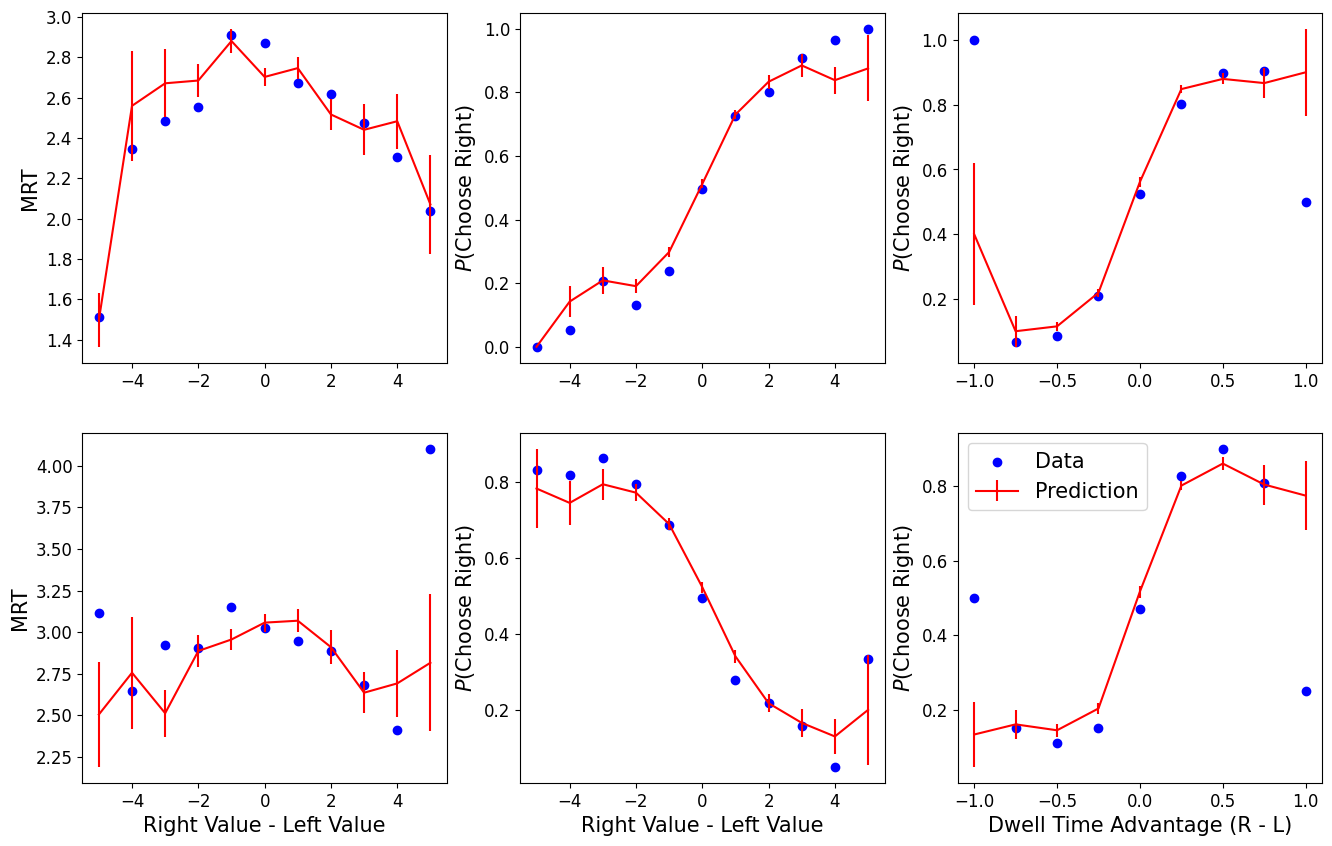

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_valuebased_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

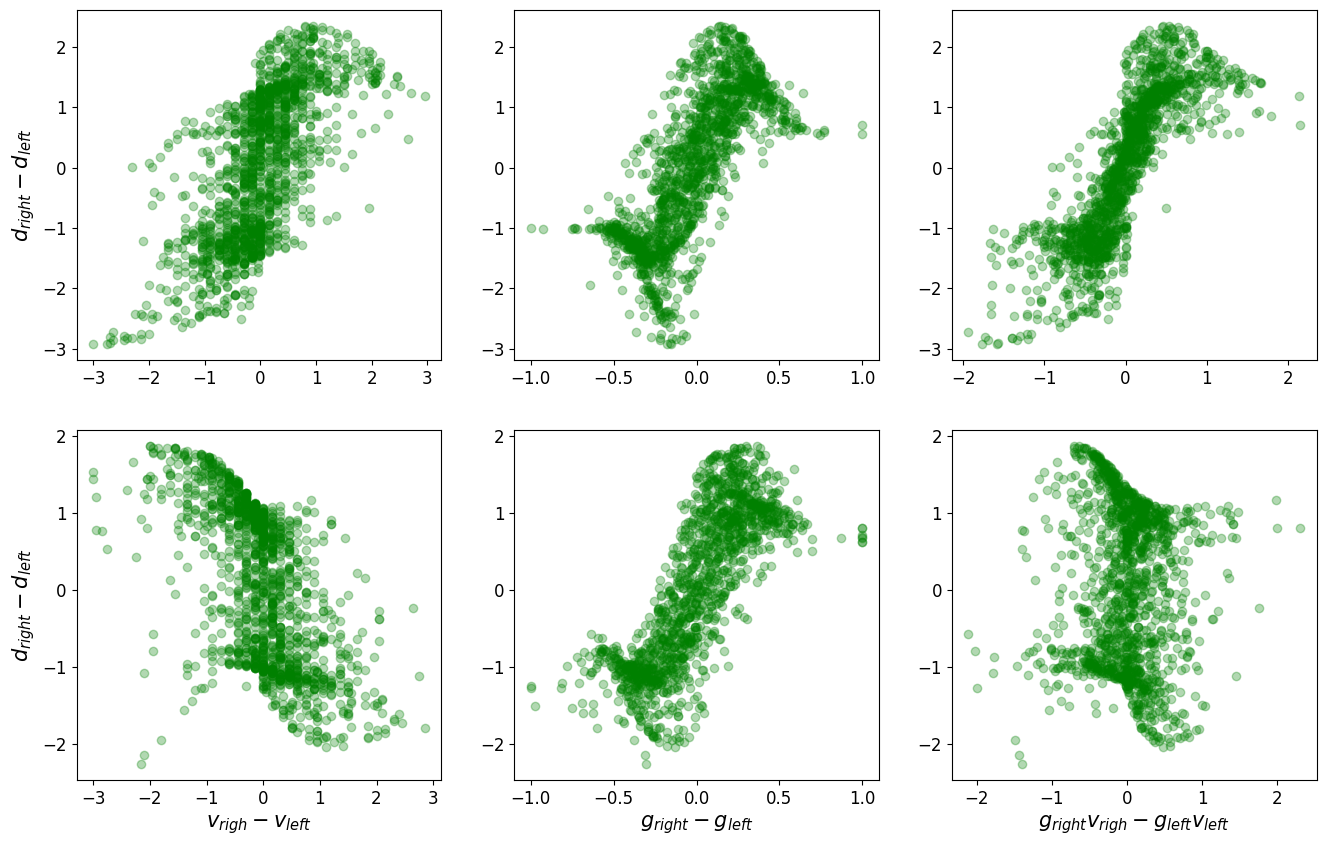

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');